<a href="https://colab.research.google.com/github/PaulFroehling/MNIST-GAN/blob/main/mnist_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from matplotlib import pyplot
import random

In [ ]:
mnist = tfds.image.MNIST
mnist = tfds.builder('mnist')
mnist.download_and_prepare()

no_samples=6000
dim_latent_space=100

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
data = mnist.as_dataset()
train_dataset, test_dataset = data['train'], data['test']

images = []
for sample in train_dataset:
  image, label = sample['image'], sample['label']
  images.append(image)


In [ ]:
train_data = np.array(images)
train_data = train_data.astype('float32')
train_data = train_data/255.0

print(np.array(train_data).shape)


(60000, 28, 28, 1)


In [ ]:
classif = tf.keras.Sequential([
                     tf.keras.layers.Conv2D(64,(3,3), strides=(2,2), input_shape=(28, 28, 1), padding='same'),
                     tf.keras.layers.LeakyReLU(alpha=0.2),
                     tf.keras.layers.Dropout(0.4),
                     tf.keras.layers.Conv2D(64,(3,3), strides=(2,2), padding='same'),
                     tf.keras.layers.LeakyReLU(alpha=0.2),
                     tf.keras.layers.Dropout(0.4),
                     tf.keras.layers.Flatten(),
                     tf.keras.layers.Dense(1, activation="sigmoid")
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
classif.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
generator = tf.keras.Sequential([
                                 tf.keras.layers.Dense(128*7*7, input_dim=dim_latent_space),
                                 tf.keras.layers.LeakyReLU(alpha=0.2),
                                 tf.keras.layers.Reshape((7,7,128)),                                
                                 tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding="same"),
                                 tf.keras.layers.LeakyReLU(alpha=0.2),
                                 tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding="same"),
                                 tf.keras.layers.LeakyReLU(alpha=0.2),
                                 tf.keras.layers.Conv2D(1, (7,7), activation='sigmoid', padding='same')
])

In [ ]:
from keras.utils.vis_utils import plot_model

def create_gan(classifier, generator):
  classifier.trainabe = False
  gan = tf.keras.Sequential()
  gan.add(generator)
  gan.add(classifier)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  gan.compile(optimizer=optimizer, loss="binary_crossentropy")
  return gan

In [ ]:
from numpy.random import randn

def generate_latent_sample(no_latent_samples=300):
   return randn(dim_latent_space * no_latent_samples).reshape(no_latent_samples, dim_latent_space)
   

def generate_fake_images(no_latent_samples=300):
  latent_sample = generate_latent_sample(no_latent_samples)
  fake_images= np.array(generator.predict(latent_sample))
  fake_labels = np.zeros((no_latent_samples,1))
  return fake_images, fake_labels

#zero-fak, one - real
def get_real_data(no_samples=300):
  indices = np.random.randint(0, train_data.shape[0], size=no_samples)
  real_samples = train_data[indices]
  real_labels = np.ones((no_samples,1))
  return real_samples, real_labels


(10, 28, 28, 1)


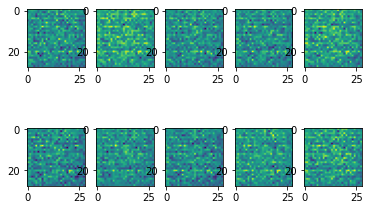

In [ ]:
test_sample = np.random.random_sample(1000)
test_sample = test_sample.reshape((10,100))

test_image= np.array(generator.predict(test_sample))
print(test_image.shape)
for i in range(0, 10):
  pyplot.subplot(2,5,1+i)
  pyplot.imshow(np.reshape(test_image[i],(28,28)))

In [ ]:
gan = create_gan(classif, generator)

In [ ]:
epochs=30
batch_size=256

for i in range(0,epochs):
  print(i)
  print(train_data.shape[0])
  batches_per_epoch = int(train_data.shape[0] / batch_size) #hier ist was falsch
  print(batches_per_epoch)
  for j in range(0, batches_per_epoch):
    fake_images, fake_labels = generate_fake_images(int(batch_size/2))
    real_images,real_labels = get_real_data(no_samples=int(batch_size/2))
    train_x_classif, train_y_class = np.vstack((real_images, fake_images)), np.vstack((real_labels, fake_labels))

    classif.trainable=True
    classif_loss= classif.train_on_batch(train_x_classif, train_y_class)
    x_gan = generate_latent_sample(batch_size)
    y_gan = np.ones((batch_size))
    classif.trainable=False
    gan_loss = gan.train_on_batch(x_gan,y_gan)
    if(j%100==0):
      print("j: "+str(j))
  
  print("classifier loss "+str(classif_loss))
  print("gan loss "+str(gan_loss))

In [ ]:
#gan.save("/tmp/gan")
generator.save("/tmp/generator")
classif.save("/tmp/classifier")

INFO:tensorflow:Assets written to: /tmp/generator/assets


INFO:tensorflow:Assets written to: /tmp/generator/assets


INFO:tensorflow:Assets written to: /tmp/classifier/assets


INFO:tensorflow:Assets written to: /tmp/classifier/assets


In [ ]:
from google.colab import files
!zip -r "/tmp/gan.zip" "/tmp/gan"
!zip -r "/tmp/generator.zip" "/tmp/generator"
!zip -r "/tmp/classifier.zip" "/tmp/classifier"

files.download("/tmp/gan.zip")
files.download("/tmp/generator.zip")
files.download("/tmp/classifier.zip")

# Neuer Abschnitt

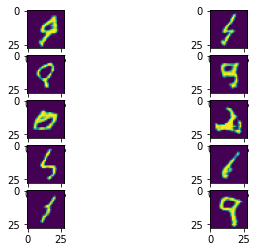

In [ ]:
#test_sample = np.random.random_sample(300)
#test_sample = test_sample.reshape((30,100))

no_examples = 10
test_sample = randn(100 * no_examples).reshape(no_examples, 100)
test_image= np.array(generator.predict(test_sample))

for i in range(0, no_examples):
  pyplot.subplot(no_examples/2,2,1+i)
  pyplot.imshow(np.reshape(test_image[i],(28,28)))


